# Network definition

In [1]:
from time import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
# Parameters
L = 6

# Load and parse the data (N instances, D features, L labels)
data = pd.read_csv('data/scene.csv') # Load data from CSV with Pandas
XY = data.values
N,DL = XY.shape
D = DL - L
Y = XY[:,0:L].astype(int)
X = XY[:,L:D+L]

# Split into train/test sets
n = int(N*6/10)
X_train = X[0:n]
Y_train = Y[0:n]
X_test = X[n:]
Y_test = Y[n:]

# Get class names
class_names = list(data.columns.values[:L])

In [3]:
class Network():

    def __init__(self, learning_rate=0.001, num_hidden_layers=2, batch_size=32, weight_decay=0.0001, treshold=0.6, n_1=128, n_2=32):
        ''' initialize the classifier with default (best) parameters '''

        # Parameters
        self.num_epoch     = 0
        self.display_step  = 10
        self.treshold      = treshold
        self.batch_size    = batch_size
        self.weight_decay  = weight_decay
        self.learning_rate = learning_rate
        self.clock         = time()

        # Network Parameters
        n_input    = 294 # Data input (line shape: 294)
        n_hidden_1 = 0
        n_hidden_2 = 0
        n_hidden_3 = 0
        n_hidden_4 = 0
        n_hidden_5 = 0

        if num_hidden_layers == 5:
            n_hidden_1 = 256
            n_hidden_2 = 128
            n_hidden_3 = 64
            n_hidden_4 = 32
            n_hidden_5 = 16
            n_O_param  = n_hidden_5
        elif num_hidden_layers == 4:
            n_hidden_1 = 128
            n_hidden_2 = 64
            n_hidden_3 = 32
            n_hidden_4 = 16
            n_O_param  = n_hidden_4
        elif num_hidden_layers == 3:
            n_hidden_1 = 128
            n_hidden_2 = 64
            n_hidden_3 = 32
            n_O_param  = n_hidden_3
        else:
            n_hidden_1 = n_1
            n_hidden_2 = n_2
            n_O_param  = n_hidden_2

        n_classes  = 6   # Classes (0-5 digits)
 
        # tf Graph input
        self.x = tf.placeholder("float", [None, n_input])
        self.y = tf.placeholder("float", [None, n_classes])

        # Store layers weight & bias
        W1 = tf.Variable(tf.random_normal([n_input, n_hidden_1]))
        W2 = tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2]))
        W3 = tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3]))
        W4 = tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4]))
        W5 = tf.Variable(tf.random_normal([n_hidden_4, n_hidden_5]))        
        WO = tf.Variable(tf.random_normal([n_O_param, n_classes]))
        b1 = tf.Variable(tf.random_normal([n_hidden_1]))
        b2 = tf.Variable(tf.random_normal([n_hidden_2]))
        b3 = tf.Variable(tf.random_normal([n_hidden_3]))
        b4 = tf.Variable(tf.random_normal([n_hidden_4]))
        b5 = tf.Variable(tf.random_normal([n_hidden_5]))
        bO = tf.Variable(tf.random_normal([n_classes]))

        # Layers
        if num_hidden_layers == 5:
            layer1 = tf.nn.sigmoid(tf.matmul(self.x, W1) + b1)
            layer2 = tf.nn.sigmoid(tf.matmul(layer1, W2) + b2)
            layer3 = tf.nn.sigmoid(tf.matmul(layer2, W3) + b3)
            layer4 = tf.nn.sigmoid(tf.matmul(layer3, W4) + b4)
            layer5 = tf.nn.sigmoid(tf.matmul(layer4, W5) + b5)
            self.pred = tf.add(tf.matmul(layer5, WO), bO)
        elif num_hidden_layers == 4:
            layer1 = tf.nn.sigmoid(tf.matmul(self.x, W1) + b1)
            layer2 = tf.nn.sigmoid(tf.matmul(layer1, W2) + b2)
            layer3 = tf.nn.sigmoid(tf.matmul(layer2, W3) + b3)
            layer4 = tf.nn.sigmoid(tf.matmul(layer3, W4) + b4)
            self.pred = tf.add(tf.matmul(layer4, WO), bO)
        elif num_hidden_layers == 3:
            layer1 = tf.nn.sigmoid(tf.matmul(self.x, W1) + b1)
            layer2 = tf.nn.sigmoid(tf.matmul(layer1, W2) + b2)
            layer3 = tf.nn.sigmoid(tf.matmul(layer2, W3) + b3)
            self.pred = tf.add(tf.matmul(layer3, WO), bO)        
        else:
            layer1 = tf.nn.sigmoid(tf.matmul(self.x, W1) + b1)
            layer2 = tf.nn.sigmoid(tf.matmul(layer1, W2) + b2)
            self.pred = tf.add(tf.matmul(layer2, WO), bO)

        # Define loss and optimizer
        weight_decay_val = self.weight_decay*tf.add_n([tf.nn.l2_loss(v) for v in tf.trainable_variables()])
        self.cost        = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=self.y, logits=self.pred)) + weight_decay_val
        self.opt         = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)

        # Initialize the variables (i.e. assign their default value)
        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)

    def fit(self,X,Y,warm_start=True,n_epochs=10):
        ''' train the network, and if warm_start, then do not reinit. the network
            (if it has already been initialized)
        '''

        batch_per_epoch = int(Y.shape[0]/self.batch_size)

        if not warm_start:
            print("No warm start. Session reset.")
            self.sess.close()
            self.__init__()

        # Training cycle
        for _ in range(n_epochs):
            self.num_epoch+=1
            avg_cost = 0.

            # Loop over all batches
            for i in range(batch_per_epoch):
                batch_x = X[self.batch_size*i:self.batch_size*(i+1),:]
                batch_y = Y[self.batch_size*i:self.batch_size*(i+1),:] 

                # Run optimization op (backprop) and cost op (to get loss value)
                _, c = self.sess.run([self.opt, self.cost], feed_dict={self.x: batch_x, self.y: batch_y})
                # Compute average loss
                avg_cost += c / batch_per_epoch

            # Display logs per epoch step
            if self.num_epoch % self.display_step == 0:
                print("Epoch: {:04d} cost={:.9f} time={:.4f}".format(self.num_epoch, avg_cost, time()-self.clock))

    def predict_proba(self,X):
        ''' return a matrix P where P[i,j] = P(Y[i,j]=1), 
        for all instances i, and labels j. '''
        predict_proba = self.sess.run(tf.nn.sigmoid(self.pred), feed_dict={self.x: X})
        # Attempted a normalisation
        #row_sums = predict_proba.sum(axis=1)
        #proba_norm = predict_proba / row_sums[:, np.newaxis]
        return predict_proba

    def predict(self,X):
        ''' return a matrix of predictions for X '''
        return (self.predict_proba(X) >= self.treshold).astype(int)

# Main test

In [4]:
# Test our classifier 
h = Network()

t0 = time()
while (time() - t0) < 120:
    h.fit(X_train,Y_train)

print("Trained %d epochs in %d seconds." % (h.num_epoch,int(time() - t0)))

Epoch: 0010 cost=2.004421009 time=0.9162
Epoch: 0020 cost=1.571571998 time=1.3006
Epoch: 0030 cost=1.267791767 time=1.6338
Epoch: 0040 cost=1.041613551 time=1.9580
Epoch: 0050 cost=0.871034094 time=2.2881
Epoch: 0060 cost=0.741811897 time=2.6503
Epoch: 0070 cost=0.643707736 time=3.0674
Epoch: 0080 cost=0.567072081 time=3.4460
Epoch: 0090 cost=0.506109527 time=3.8360
Epoch: 0100 cost=0.457085456 time=4.1950
Epoch: 0110 cost=0.416987753 time=4.5193
Epoch: 0120 cost=0.383714835 time=4.8686
Epoch: 0130 cost=0.355762279 time=5.2218
Epoch: 0140 cost=0.331979207 time=5.5636
Epoch: 0150 cost=0.311550111 time=5.8981
Epoch: 0160 cost=0.293829296 time=6.2209
Epoch: 0170 cost=0.278307318 time=6.5499
Epoch: 0180 cost=0.264597621 time=6.8750
Epoch: 0190 cost=0.252402461 time=7.1935
Epoch: 0200 cost=0.241492819 time=7.5174
Epoch: 0210 cost=0.231691006 time=7.8369
Epoch: 0220 cost=0.222848644 time=8.1735
Epoch: 0230 cost=0.214839168 time=8.4908
Epoch: 0240 cost=0.207554830 time=8.8109
Epoch: 0250 cost

Epoch: 1970 cost=0.101135965 time=65.7314
Epoch: 1980 cost=0.099326508 time=66.0574
Epoch: 1990 cost=0.098753742 time=66.4131
Epoch: 2000 cost=0.098445183 time=66.7443
Epoch: 2010 cost=0.098251316 time=67.0634
Epoch: 2020 cost=0.098123293 time=67.3886
Epoch: 2030 cost=0.098048049 time=67.8567
Epoch: 2040 cost=0.098018010 time=68.4087
Epoch: 2050 cost=0.098018614 time=68.7844
Epoch: 2060 cost=0.098035914 time=69.1637
Epoch: 2070 cost=0.098062043 time=69.4808
Epoch: 2080 cost=0.098093975 time=69.8001
Epoch: 2090 cost=0.098132256 time=70.1408
Epoch: 2100 cost=0.098183142 time=70.4696
Epoch: 2110 cost=0.098267192 time=70.7863
Epoch: 2120 cost=0.098444665 time=71.1049
Epoch: 2130 cost=0.098925578 time=71.4194
Epoch: 2140 cost=0.101196792 time=71.7355
Epoch: 2150 cost=0.101427305 time=72.0504
Epoch: 2160 cost=0.099566858 time=72.3632
Epoch: 2170 cost=0.098982654 time=72.6794
Epoch: 2180 cost=0.098615364 time=72.9945
Epoch: 2190 cost=0.098346359 time=73.3129
Epoch: 2200 cost=0.098142055 time=

In [5]:
def results(X_test):
    proba = h.predict_proba(X_test)
    Y_pred = h.predict(X_test)
    print("sum(sum(Y_pred)) = {}".format(sum(sum(Y_pred))))
    print("sum(sum(Y_test)) = {}".format(sum(sum(Y_test))))
    tester = Y_pred != Y_test
    loss = np.mean(tester)
    print("Hamming loss     =", loss)

    for i in range(len(tester)):
        if any(tester[i]):
            formattedProba = [ '%.2f' % elem for elem in proba[i] ]
            print("{:03d} : PROB = {} | PRED = {}  |  TEST = {}".format(i, formattedProba, Y_pred[i],Y_test[i]))

In [6]:
results(X_test)

sum(sum(Y_pred)) = 805
sum(sum(Y_test)) = 859
Hamming loss     = 0.08583333333333333
000 : PROB = ['0.06', '0.00', '0.00', '0.00', '0.52', '0.41'] | PRED = [0 0 0 0 1 0]  |  TEST = [0 0 0 0 0 1]
002 : PROB = ['0.00', '0.00', '0.00', '0.61', '0.38', '0.00'] | PRED = [0 0 0 1 0 0]  |  TEST = [0 0 0 1 1 0]
007 : PROB = ['0.00', '0.01', '0.00', '0.02', '0.96', '0.00'] | PRED = [0 0 0 0 1 0]  |  TEST = [0 0 0 1 0 0]
010 : PROB = ['0.00', '0.00', '0.00', '0.00', '0.91', '0.08'] | PRED = [0 0 0 0 1 0]  |  TEST = [0 0 0 1 0 0]
014 : PROB = ['0.05', '0.00', '0.77', '0.18', '0.00', '0.00'] | PRED = [0 0 1 0 0 0]  |  TEST = [0 0 1 1 0 0]
015 : PROB = ['0.47', '0.00', '0.04', '0.00', '0.00', '0.48'] | PRED = [1 0 0 0 0 1]  |  TEST = [0 0 1 0 0 0]
016 : PROB = ['0.01', '0.00', '0.00', '0.00', '0.37', '0.62'] | PRED = [0 0 0 0 0 1]  |  TEST = [0 0 0 0 1 0]
018 : PROB = ['0.97', '0.00', '0.02', '0.01', '0.00', '0.00'] | PRED = [1 0 0 0 0 0]  |  TEST = [0 0 0 0 0 1]
019 : PROB = ['0.00', '0.00', '0.00

# First test

## For nb_layers and learning_rate

In [4]:
def run_network_1(nb_layers=2, learning_rate=0.001):
    
    print("\n\n########## Training NN with nb_layers={}, learning_rate={} ##########".format(nb_layers,learning_rate))

    t0 = time()
    h = Network(learning_rate=learning_rate, num_hidden_layers=nb_layers)

    t0 = time()
    while (time() - t0) < 120:
        h.fit(X_train,Y_train)

    print("Trained %d epochs in %d seconds." % (h.num_epoch,int(time() - t0)))

    proba = h.predict_proba(X_test)
    Y_pred = (proba >= 0.5).astype(int)
    print("sum(sum(Y_pred)) = {}".format(sum(sum(Y_pred))))
    print("sum(sum(Y_test)) = {}".format(sum(sum(Y_test))))
    tester = Y_pred != Y_test
    loss = np.mean(tester)
    print("Hamming loss     =", loss)

    return h.num_epoch, loss

In [6]:
losses = dict()

In [7]:
for i in nb_layers:
    for j in learning_rates:
        key = "{}+{}".format(i,j)
        epoch, loss = run_network_1(nb_layers=i, learning_rate=j)
        losses[key]=loss



########## Training NN with nb_layers=2, learning_rate=0.0001 ##########
Epoch: 0010 cost=2.896786493 time=0.8213
Epoch: 0020 cost=2.552489138 time=1.1792
Epoch: 0030 cost=2.463586313 time=1.5534
Epoch: 0040 cost=2.389666796 time=1.9000
Epoch: 0050 cost=2.317776448 time=2.2549
Epoch: 0060 cost=2.243865830 time=2.6028
Epoch: 0070 cost=2.171614224 time=2.9471
Epoch: 0080 cost=2.101384205 time=3.2935
Epoch: 0090 cost=2.035393125 time=3.6373
Epoch: 0100 cost=1.973168021 time=3.9791
Epoch: 0110 cost=1.914039025 time=4.3205
Epoch: 0120 cost=1.857096803 time=4.6660
Epoch: 0130 cost=1.801862851 time=5.0130
Epoch: 0140 cost=1.748218015 time=5.3547
Epoch: 0150 cost=1.696225640 time=5.6972
Epoch: 0160 cost=1.645926127 time=6.0386
Epoch: 0170 cost=1.597407880 time=6.3820
Epoch: 0180 cost=1.550648585 time=6.7237
Epoch: 0190 cost=1.505548748 time=7.0687
Epoch: 0200 cost=1.462053615 time=7.4108
Epoch: 0210 cost=1.420137727 time=7.7496
Epoch: 0220 cost=1.379787198 time=8.0974
Epoch: 0230 cost=1.3409

Epoch: 1950 cost=0.226590642 time=67.7999
Epoch: 1960 cost=0.225646938 time=68.1400
Epoch: 1970 cost=0.224713209 time=68.4818
Epoch: 1980 cost=0.223789320 time=68.8175
Epoch: 1990 cost=0.222875093 time=69.1571
Epoch: 2000 cost=0.221970380 time=69.4949
Epoch: 2010 cost=0.221075092 time=69.8295
Epoch: 2020 cost=0.220189040 time=70.1656
Epoch: 2030 cost=0.219312102 time=70.5009
Epoch: 2040 cost=0.218444170 time=70.8430
Epoch: 2050 cost=0.217585111 time=71.1799
Epoch: 2060 cost=0.216734754 time=71.5181
Epoch: 2070 cost=0.215893038 time=71.8542
Epoch: 2080 cost=0.215059796 time=72.1943
Epoch: 2090 cost=0.214234927 time=72.5333
Epoch: 2100 cost=0.213418282 time=72.8717
Epoch: 2110 cost=0.212609842 time=73.2123
Epoch: 2120 cost=0.211809393 time=73.5507
Epoch: 2130 cost=0.211016867 time=73.8890
Epoch: 2140 cost=0.210232177 time=74.2263
Epoch: 2150 cost=0.209455175 time=74.5672
Epoch: 2160 cost=0.208685780 time=74.9038
Epoch: 2170 cost=0.207923904 time=75.2571
Epoch: 2180 cost=0.207169429 time=

Epoch: 0350 cost=0.158418125 time=14.7197
Epoch: 0360 cost=0.158144458 time=15.1206
Epoch: 0370 cost=0.168636777 time=15.5248
Epoch: 0380 cost=0.152605249 time=15.9411
Epoch: 0390 cost=0.149122979 time=16.3409
Epoch: 0400 cost=0.146570229 time=16.7437
Epoch: 0410 cost=0.144441852 time=17.1451
Epoch: 0420 cost=0.142531067 time=17.5456
Epoch: 0430 cost=0.140740700 time=17.9469
Epoch: 0440 cost=0.139032023 time=18.3457
Epoch: 0450 cost=0.137393871 time=18.7485
Epoch: 0460 cost=0.135840964 time=19.1507
Epoch: 0470 cost=0.134432020 time=19.5565
Epoch: 0480 cost=0.133270518 time=19.9649
Epoch: 0490 cost=0.132499593 time=20.7088
Epoch: 0500 cost=0.132299200 time=21.5098
Epoch: 0510 cost=0.132885232 time=22.2824
Epoch: 0520 cost=0.135365406 time=22.9721
Epoch: 0530 cost=0.150080178 time=23.7493
Epoch: 0540 cost=0.130207292 time=24.4121
Epoch: 0550 cost=0.127499427 time=25.0798
Epoch: 0560 cost=0.125876591 time=25.7947
Epoch: 0570 cost=0.124566349 time=26.3235
Epoch: 0580 cost=0.123435494 time=

Epoch: 2310 cost=0.098535898 time=98.8931
Epoch: 2320 cost=0.098660385 time=99.2931
Epoch: 2330 cost=0.098793251 time=99.6982
Epoch: 2340 cost=0.098899534 time=100.0988
Epoch: 2350 cost=0.098962593 time=100.5072
Epoch: 2360 cost=0.099087852 time=100.9086
Epoch: 2370 cost=0.099860069 time=101.3090
Epoch: 2380 cost=0.104352934 time=101.7133
Epoch: 2390 cost=0.098617202 time=102.1140
Epoch: 2400 cost=0.098184141 time=102.5150
Epoch: 2410 cost=0.098103506 time=102.9196
Epoch: 2420 cost=0.098133511 time=103.3230
Epoch: 2430 cost=0.098212254 time=103.7301
Epoch: 2440 cost=0.098322471 time=104.1386
Epoch: 2450 cost=0.098453460 time=104.5597
Epoch: 2460 cost=0.098579220 time=104.9617
Epoch: 2470 cost=0.098669457 time=105.3601
Epoch: 2480 cost=0.098755204 time=105.7607
Epoch: 2490 cost=0.099079083 time=106.1691
Epoch: 2500 cost=0.100703377 time=106.5771
Epoch: 2510 cost=0.101695948 time=106.9770
Epoch: 2520 cost=0.098072395 time=107.3760
Epoch: 2530 cost=0.097925494 time=107.7851
Epoch: 2540 co

Epoch: 1360 cost=0.134407475 time=67.9389
Epoch: 1370 cost=0.158398973 time=68.4005
Epoch: 1380 cost=0.117397257 time=68.8644
Epoch: 1390 cost=0.113968359 time=69.3299
Epoch: 1400 cost=0.149929776 time=69.7941
Epoch: 1410 cost=0.122991190 time=70.2531
Epoch: 1420 cost=0.135181590 time=70.7146
Epoch: 1430 cost=0.113591553 time=71.1780
Epoch: 1440 cost=0.113187559 time=71.6401
Epoch: 1450 cost=0.168031210 time=72.1021
Epoch: 1460 cost=0.142239452 time=72.5598
Epoch: 1470 cost=0.113537679 time=73.0224
Epoch: 1480 cost=0.112907613 time=73.4808
Epoch: 1490 cost=0.178637976 time=74.0301
Epoch: 1500 cost=0.119824698 time=74.5303
Epoch: 1510 cost=0.146246694 time=75.0053
Epoch: 1520 cost=0.118808699 time=75.4615
Epoch: 1530 cost=0.112851736 time=75.9246
Epoch: 1540 cost=0.167537624 time=76.3836
Epoch: 1550 cost=0.147315533 time=76.8458
Epoch: 1560 cost=0.119213343 time=77.3025
Epoch: 1570 cost=0.118821425 time=77.7606
Epoch: 1580 cost=0.164009368 time=78.2174
Epoch: 1590 cost=0.119937815 time=

Epoch: 0760 cost=0.530649508 time=45.3627
Epoch: 0770 cost=0.442435180 time=45.9223
Epoch: 0780 cost=0.449909341 time=46.4617
Epoch: 0790 cost=0.490351796 time=47.0002
Epoch: 0800 cost=0.460228271 time=47.5445
Epoch: 0810 cost=0.545256708 time=48.0798
Epoch: 0820 cost=0.564643253 time=48.6260
Epoch: 0830 cost=0.421823467 time=49.1812
Epoch: 0840 cost=0.442811207 time=49.7424
Epoch: 0850 cost=0.437048215 time=50.2851
Epoch: 0860 cost=0.441276339 time=50.8292
Epoch: 0870 cost=0.545849893 time=51.3683
Epoch: 0880 cost=0.451367290 time=51.9197
Epoch: 0890 cost=0.444633803 time=52.4755
Epoch: 0900 cost=0.461256212 time=53.0384
Epoch: 0910 cost=0.457870784 time=53.6304
Epoch: 0920 cost=0.450782195 time=54.2631
Epoch: 0930 cost=0.461273628 time=54.8518
Epoch: 0940 cost=0.580535094 time=55.4211
Epoch: 0950 cost=0.455784636 time=56.0120
Epoch: 0960 cost=0.451473760 time=56.5818
Epoch: 0970 cost=0.462057841 time=57.1644
Epoch: 0980 cost=0.476552800 time=57.7143
Epoch: 0990 cost=0.451348735 time=

Epoch: 0590 cost=0.839828166 time=43.2181
Epoch: 0600 cost=0.822777736 time=43.8962
Epoch: 0610 cost=0.806594822 time=44.5748
Epoch: 0620 cost=0.791214362 time=45.2453
Epoch: 0630 cost=0.776576446 time=45.9163
Epoch: 0640 cost=0.762626272 time=46.5783
Epoch: 0650 cost=0.749312557 time=47.2504
Epoch: 0660 cost=0.736587687 time=47.9180
Epoch: 0670 cost=0.724409175 time=48.5895
Epoch: 0680 cost=0.712736216 time=49.2795
Epoch: 0690 cost=0.701532860 time=50.0162
Epoch: 0700 cost=0.690765396 time=50.8204
Epoch: 0710 cost=0.680403021 time=51.5756
Epoch: 0720 cost=0.670417953 time=52.3940
Epoch: 0730 cost=0.660784064 time=53.1239
Epoch: 0740 cost=0.651478238 time=53.9321
Epoch: 0750 cost=0.642478633 time=54.6523
Epoch: 0760 cost=0.633765459 time=55.4129
Epoch: 0770 cost=0.625320610 time=56.1889
Epoch: 0780 cost=0.617128044 time=56.9490
Epoch: 0790 cost=0.609172189 time=57.6301
Epoch: 0800 cost=0.601439445 time=58.3285
Epoch: 0810 cost=0.593916751 time=59.0067
Epoch: 0820 cost=0.586592515 time=

Epoch: 0780 cost=0.114194293 time=70.7109
Epoch: 0790 cost=0.111198387 time=71.4843
Epoch: 0800 cost=0.108590729 time=72.2539
Epoch: 0810 cost=0.106896761 time=73.0204
Epoch: 0820 cost=0.105724497 time=73.7821
Epoch: 0830 cost=0.104906976 time=74.5511
Epoch: 0840 cost=0.104350781 time=75.3196
Epoch: 0850 cost=0.104008587 time=76.0897
Epoch: 0860 cost=0.103938261 time=76.8543
Epoch: 0870 cost=0.104844292 time=77.6097
Epoch: 0880 cost=0.120404324 time=78.3804
Epoch: 0890 cost=0.112762154 time=79.1531
Epoch: 0900 cost=0.106578030 time=79.9192
Epoch: 0910 cost=0.103738847 time=80.6822
Epoch: 0920 cost=0.102418664 time=81.4491
Epoch: 0930 cost=0.101427583 time=82.2233
Epoch: 0940 cost=0.100702633 time=82.9820
Epoch: 0950 cost=0.100230437 time=83.7459
Epoch: 0960 cost=0.099954196 time=84.5071
Epoch: 0970 cost=0.099833172 time=85.2757
Epoch: 0980 cost=0.100013274 time=86.0568
Epoch: 0990 cost=0.101375637 time=86.9016
Epoch: 1000 cost=0.120978547 time=87.8236
Epoch: 1010 cost=0.105248831 time=

Epoch: 1250 cost=0.126242492 time=108.4017
Epoch: 1260 cost=0.153346951 time=109.2422
Epoch: 1270 cost=0.160922747 time=110.0868
Epoch: 1280 cost=0.122770508 time=111.0026
Epoch: 1290 cost=0.174772665 time=111.8670
Epoch: 1300 cost=0.112727513 time=112.7108
Epoch: 1310 cost=0.124957457 time=113.5652
Epoch: 1320 cost=0.152492628 time=114.4234
Epoch: 1330 cost=0.109221812 time=115.2878
Epoch: 1340 cost=0.172057389 time=116.1436
Epoch: 1350 cost=0.122499402 time=116.9947
Epoch: 1360 cost=0.134363462 time=117.8423
Epoch: 1370 cost=0.117902481 time=118.6949
Epoch: 1380 cost=0.130813255 time=119.5467
Epoch: 1390 cost=0.175373277 time=120.3949
Epoch: 1400 cost=0.121105928 time=121.2447
Epoch: 1410 cost=0.112968096 time=122.0937
Trained 1410 epochs in 120 seconds.
sum(sum(Y_pred)) = 783
sum(sum(Y_test)) = 859
Hamming loss     = 0.09083333333333334


########## Training NN with nb_layers=3, learning_rate=0.1 ##########
Epoch: 0010 cost=0.488119821 time=3.6903
Epoch: 0020 cost=0.498627969 time=4

Epoch: 0410 cost=1.594083184 time=45.7261
Epoch: 0420 cost=1.506954658 time=46.7682
Epoch: 0430 cost=1.426401421 time=47.8132
Epoch: 0440 cost=1.351962087 time=48.8538
Epoch: 0450 cost=1.283207917 time=49.9175
Epoch: 0460 cost=1.219731402 time=50.9532
Epoch: 0470 cost=1.161148283 time=51.9866
Epoch: 0480 cost=1.107099178 time=53.0167
Epoch: 0490 cost=1.057243428 time=54.0549
Epoch: 0500 cost=1.011261368 time=55.0932
Epoch: 0510 cost=0.968856114 time=56.1297
Epoch: 0520 cost=0.929750869 time=57.1662
Epoch: 0530 cost=0.893687041 time=58.2035
Epoch: 0540 cost=0.860423219 time=59.2400
Epoch: 0550 cost=0.829733673 time=60.2815
Epoch: 0560 cost=0.801408085 time=61.3199
Epoch: 0570 cost=0.775251044 time=62.3934
Epoch: 0580 cost=0.751081687 time=63.5018
Epoch: 0590 cost=0.728732595 time=64.5874
Epoch: 0600 cost=0.708049035 time=65.6728
Epoch: 0610 cost=0.688889046 time=66.7656
Epoch: 0620 cost=0.671121007 time=67.8506
Epoch: 0630 cost=0.654624827 time=68.9322
Epoch: 0640 cost=0.639290065 time=

Epoch: 0030 cost=0.304282433 time=7.9838
Epoch: 0040 cost=0.259937066 time=9.1827
Epoch: 0050 cost=0.243923045 time=10.3644
Epoch: 0060 cost=0.226190900 time=11.5551
Epoch: 0070 cost=0.218662284 time=12.7444
Epoch: 0080 cost=0.209767972 time=13.9336
Epoch: 0090 cost=0.209775035 time=15.1180
Epoch: 0100 cost=0.231407279 time=16.2971
Epoch: 0110 cost=0.190986481 time=17.4822
Epoch: 0120 cost=0.216884523 time=18.6735
Epoch: 0130 cost=0.200637791 time=19.8635
Epoch: 0140 cost=0.180796077 time=21.0522
Epoch: 0150 cost=0.189818481 time=22.2397
Epoch: 0160 cost=0.166746837 time=23.4306
Epoch: 0170 cost=0.188197887 time=24.6264
Epoch: 0180 cost=0.153045627 time=25.8283
Epoch: 0190 cost=0.169944875 time=27.0136
Epoch: 0200 cost=0.154170321 time=28.1988
Epoch: 0210 cost=0.179670852 time=29.3911
Epoch: 0220 cost=0.159275940 time=30.5849
Epoch: 0230 cost=0.161951965 time=31.7722
Epoch: 0240 cost=0.164185333 time=32.9624
Epoch: 0250 cost=0.165404170 time=34.1519
Epoch: 0260 cost=0.156479756 time=35

Epoch: 0920 cost=0.474986891 time=121.2731
Epoch: 0930 cost=0.474872295 time=122.5279
Epoch: 0940 cost=0.477654413 time=123.7831
Epoch: 0950 cost=0.475295196 time=125.0198
Trained 950 epochs in 120 seconds.
sum(sum(Y_pred)) = 0
sum(sum(Y_test)) = 859
Hamming loss     = 0.17895833333333333


########## Training NN with nb_layers=5, learning_rate=0.0001 ##########
Epoch: 0010 cost=32.760318184 time=7.1046
Epoch: 0020 cost=30.754134274 time=8.5533
Epoch: 0030 cost=28.961842346 time=10.0080
Epoch: 0040 cost=27.293147182 time=11.4578
Epoch: 0050 cost=25.723256254 time=12.9223
Epoch: 0060 cost=24.237808132 time=14.3900
Epoch: 0070 cost=22.830280638 time=15.8524
Epoch: 0080 cost=21.497506571 time=17.3114
Epoch: 0090 cost=20.236941910 time=18.7647
Epoch: 0100 cost=19.044025993 time=20.2018
Epoch: 0110 cost=17.914435101 time=21.6577
Epoch: 0120 cost=16.844618177 time=23.1141
Epoch: 0130 cost=15.831945443 time=24.5698
Epoch: 0140 cost=14.874421883 time=26.0228
Epoch: 0150 cost=13.969612956 time=

Epoch: 0200 cost=0.207057296 time=42.4754
Epoch: 0210 cost=0.200716120 time=44.2312
Epoch: 0220 cost=0.198341522 time=45.9812
Epoch: 0230 cost=0.167847492 time=47.7200
Epoch: 0240 cost=0.212388062 time=49.4688
Epoch: 0250 cost=0.175196166 time=51.2149
Epoch: 0260 cost=0.185019333 time=52.9698
Epoch: 0270 cost=0.180212868 time=54.7435
Epoch: 0280 cost=0.194655556 time=56.5187
Epoch: 0290 cost=0.186850061 time=58.2804
Epoch: 0300 cost=0.193788110 time=60.0498
Epoch: 0310 cost=0.195667034 time=61.8322
Epoch: 0320 cost=0.192113606 time=63.5826
Epoch: 0330 cost=0.203615558 time=65.3571
Epoch: 0340 cost=0.214758607 time=67.1079
Epoch: 0350 cost=0.202261949 time=68.8626
Epoch: 0360 cost=0.164802903 time=70.6248
Epoch: 0370 cost=0.154795904 time=72.4113
Epoch: 0380 cost=0.170910232 time=74.2110
Epoch: 0390 cost=0.159869324 time=76.0224
Epoch: 0400 cost=0.186161384 time=77.8361
Epoch: 0410 cost=0.170580893 time=79.6962
Epoch: 0420 cost=0.164375604 time=81.5289
Epoch: 0430 cost=0.156102000 time=

## For batch_size and weight_decay

In [4]:
def run_network_2(batch_size, weight_decay):
    
    print("\n\n########## Training NN with batch_size={}, weight_decay={} ##########".format(batch_size,weight_decay))

    t0 = time()
    h = Network(batch_size=batch_size, weight_decay=weight_decay)

    t0 = time()
    while (time() - t0) < 120:
        h.fit(X_train,Y_train)

    print("Trained %d epochs in %d seconds." % (h.num_epoch,int(time() - t0)))

    proba = h.predict_proba(X_test)
    Y_pred = (proba >= 0.5).astype(int)
    print("sum(sum(Y_pred)) = {}".format(sum(sum(Y_pred))))
    print("sum(sum(Y_test)) = {}".format(sum(sum(Y_test))))
    tester = Y_pred != Y_test
    loss = np.mean(tester)
    print("Hamming loss     =", loss)

    return h.num_epoch, loss

In [5]:
batch_sizes    = [8,16,32,64]
weight_decays  = [0,0.00001, 0.0001, 0.001]
losses_2 = dict()

for i in batch_sizes:
    for j in weight_decays:
        key = "{}+{}".format(i,j)
        epoch, loss = run_network_2(batch_size=i, weight_decay=j)
        losses_2[key]=loss



########## Training NN with batch_size=8, weight_decay=0 ##########
Epoch: 0010 cost=0.219518254 time=1.6063
Epoch: 0020 cost=0.145926224 time=2.6839
Epoch: 0030 cost=0.100389025 time=3.7346
Epoch: 0040 cost=0.067197681 time=4.7900
Epoch: 0050 cost=0.043826619 time=5.8387
Epoch: 0060 cost=0.027003510 time=6.8864
Epoch: 0070 cost=0.015956503 time=7.9330
Epoch: 0080 cost=0.009281644 time=8.9965
Epoch: 0090 cost=0.005273682 time=10.0469
Epoch: 0100 cost=0.003014542 time=11.1134
Epoch: 0110 cost=0.001766231 time=12.1693
Epoch: 0120 cost=0.001053789 time=13.2253
Epoch: 0130 cost=0.000660168 time=14.4281
Epoch: 0140 cost=0.000457909 time=15.5011
Epoch: 0150 cost=0.000580091 time=16.5592
Epoch: 0160 cost=0.000387946 time=17.6166
Epoch: 0170 cost=0.000344619 time=18.6699
Epoch: 0180 cost=0.000313746 time=19.7302
Epoch: 0190 cost=0.000284591 time=20.8106
Epoch: 0200 cost=0.000258711 time=21.9079
Epoch: 0210 cost=0.000238453 time=22.9916
Epoch: 0220 cost=0.000224430 time=24.0667
Epoch: 0230 co

Epoch: 0030 cost=0.691870537 time=6.8643
Epoch: 0040 cost=0.543737931 time=8.8444
Epoch: 0050 cost=0.448702607 time=10.8102
Epoch: 0060 cost=0.382957749 time=12.8529
Epoch: 0070 cost=0.335375592 time=14.8811
Epoch: 0080 cost=0.299915088 time=17.1076
Epoch: 0090 cost=0.272519290 time=19.1863
Epoch: 0100 cost=0.250674718 time=22.1229
Epoch: 0110 cost=0.232876688 time=24.2644
Epoch: 0120 cost=0.218180818 time=26.2627
Epoch: 0130 cost=0.205879034 time=28.6072
Epoch: 0140 cost=0.195459511 time=30.9476
Epoch: 0150 cost=0.186568439 time=33.0208
Epoch: 0160 cost=0.178929357 time=35.0316
Epoch: 0170 cost=0.172307579 time=37.1467
Epoch: 0180 cost=0.166508782 time=38.9621
Epoch: 0190 cost=0.161385315 time=40.7598
Epoch: 0200 cost=0.156829823 time=42.5327
Epoch: 0210 cost=0.152758252 time=44.3854
Epoch: 0220 cost=0.149102863 time=46.1927
Epoch: 0230 cost=0.145810199 time=48.1648
Epoch: 0240 cost=0.142828046 time=50.2826
Epoch: 0250 cost=0.140098288 time=52.5200
Epoch: 0260 cost=0.137581312 time=54

Epoch: 0680 cost=0.000197050 time=66.5174
Epoch: 0690 cost=0.000197041 time=67.4681
Epoch: 0700 cost=0.000197033 time=68.4205
Epoch: 0710 cost=0.000197027 time=69.3753
Epoch: 0720 cost=0.000197023 time=70.3248
Epoch: 0730 cost=0.000197019 time=71.2762
Epoch: 0740 cost=0.000197016 time=72.2280
Epoch: 0750 cost=0.000197014 time=73.1809
Epoch: 0760 cost=0.000197012 time=74.1297
Epoch: 0770 cost=0.000197010 time=75.0774
Epoch: 0780 cost=0.000197009 time=76.0304
Epoch: 0790 cost=0.000197007 time=76.9755
Epoch: 0800 cost=0.000197006 time=77.9284
Epoch: 0810 cost=0.000197005 time=78.8759
Epoch: 0820 cost=0.000197005 time=79.8258
Epoch: 0830 cost=0.000197004 time=80.7770
Epoch: 0840 cost=0.000197003 time=81.7313
Epoch: 0850 cost=0.000197003 time=82.6809
Epoch: 0860 cost=0.000197002 time=83.6393
Epoch: 0870 cost=0.000197002 time=84.5899
Epoch: 0880 cost=0.000197001 time=85.5410
Epoch: 0890 cost=0.000197001 time=86.4891
Epoch: 0900 cost=0.000197001 time=87.4453
Epoch: 0910 cost=0.000197000 time=

Epoch: 0500 cost=0.117347031 time=79.0624
Epoch: 0510 cost=0.115875369 time=80.5792
Epoch: 0520 cost=0.115129614 time=82.0903
Epoch: 0530 cost=0.114516752 time=83.6071
Epoch: 0540 cost=0.114009498 time=85.1298
Epoch: 0550 cost=0.113614943 time=86.6663
Epoch: 0560 cost=0.112895865 time=88.1867
Epoch: 0570 cost=0.120856092 time=89.7284
Epoch: 0580 cost=0.112459661 time=91.2793
Epoch: 0590 cost=0.111579245 time=92.8058
Epoch: 0600 cost=0.111009838 time=94.4087
Epoch: 0610 cost=0.110543213 time=95.9608
Epoch: 0620 cost=0.110128121 time=97.5083
Epoch: 0630 cost=0.109662617 time=99.0462
Epoch: 0640 cost=0.109009339 time=100.5754
Epoch: 0650 cost=0.108813122 time=102.0931
Epoch: 0660 cost=0.111650450 time=103.6183
Epoch: 0670 cost=0.110215555 time=105.1388
Epoch: 0680 cost=0.109297621 time=106.6622
Epoch: 0690 cost=0.108706065 time=108.1826
Epoch: 0700 cost=0.108198329 time=109.7040
Epoch: 0710 cost=0.107737504 time=111.2318
Epoch: 0720 cost=0.107286410 time=112.7495
Epoch: 0730 cost=0.106810

Epoch: 0870 cost=0.000000051 time=73.5790
Epoch: 0880 cost=0.000000046 time=74.3243
Epoch: 0890 cost=0.000000041 time=75.0598
Epoch: 0900 cost=0.000000037 time=75.7964
Epoch: 0910 cost=0.000000033 time=76.5377
Epoch: 0920 cost=0.000000030 time=77.2828
Epoch: 0930 cost=0.000000028 time=78.0256
Epoch: 0940 cost=0.000000025 time=78.7792
Epoch: 0950 cost=0.000000023 time=79.5134
Epoch: 0960 cost=0.000000022 time=80.2562
Epoch: 0970 cost=0.000000020 time=81.0069
Epoch: 0980 cost=0.000000019 time=81.7647
Epoch: 0990 cost=0.000000017 time=82.5050
Epoch: 1000 cost=0.000000016 time=83.2514
Epoch: 1010 cost=0.000000015 time=83.9858
Epoch: 1020 cost=0.000000014 time=84.7227
Epoch: 1030 cost=0.000000014 time=85.4668
Epoch: 1040 cost=0.000000013 time=86.2333
Epoch: 1050 cost=0.000000012 time=86.9732
Epoch: 1060 cost=0.000000012 time=87.7245
Epoch: 1070 cost=0.000000011 time=88.5229
Epoch: 1080 cost=0.000000011 time=89.2895
Epoch: 1090 cost=0.000000010 time=90.0491
Epoch: 1100 cost=0.000000010 time=

Epoch: 0010 cost=14.202727885 time=6.9405
Epoch: 0020 cost=8.503355078 time=8.2829
Epoch: 0030 cost=5.195554901 time=9.3883
Epoch: 0040 cost=3.247033770 time=10.6702
Epoch: 0050 cost=2.093492340 time=11.7856
Epoch: 0060 cost=1.409480817 time=12.9268
Epoch: 0070 cost=1.002265178 time=14.1143
Epoch: 0080 cost=0.757610857 time=15.2034
Epoch: 0090 cost=0.607640397 time=16.3400
Epoch: 0100 cost=0.512275946 time=17.5152
Epoch: 0110 cost=0.448413795 time=18.8724
Epoch: 0120 cost=0.402891735 time=20.0432
Epoch: 0130 cost=0.368364500 time=21.1843
Epoch: 0140 cost=0.340774578 time=22.5098
Epoch: 0150 cost=0.317882617 time=23.6982
Epoch: 0160 cost=0.298399954 time=24.9374
Epoch: 0170 cost=0.281526669 time=26.2901
Epoch: 0180 cost=0.266747573 time=27.3688
Epoch: 0190 cost=0.253710625 time=28.5133
Epoch: 0200 cost=0.242151000 time=30.0922
Epoch: 0210 cost=0.231849436 time=31.3506
Epoch: 0220 cost=0.222626930 time=32.6098
Epoch: 0230 cost=0.214336380 time=33.7865
Epoch: 0240 cost=0.206855308 time=35

Epoch: 0920 cost=0.331464243 time=121.8887
Epoch: 0930 cost=0.331448046 time=123.0487
Epoch: 0940 cost=0.331432312 time=124.2140
Epoch: 0950 cost=0.331417037 time=125.4143
Epoch: 0960 cost=0.331402203 time=126.6151
Trained 960 epochs in 121 seconds.
sum(sum(Y_pred)) = 530
sum(sum(Y_test)) = 859
Hamming loss     = 0.09979166666666667


########## Training NN with batch_size=64, weight_decay=0 ##########
Epoch: 0010 cost=0.350553321 time=6.7373
Epoch: 0020 cost=0.278826707 time=7.2774
Epoch: 0030 cost=0.241840310 time=7.8850
Epoch: 0040 cost=0.213442132 time=8.4112
Epoch: 0050 cost=0.188626571 time=9.0619
Epoch: 0060 cost=0.166041018 time=9.5962
Epoch: 0070 cost=0.145289133 time=10.1260
Epoch: 0080 cost=0.127550325 time=10.6303
Epoch: 0090 cost=0.112175831 time=11.1266
Epoch: 0100 cost=0.098458279 time=11.6403
Epoch: 0110 cost=0.086135011 time=12.1643
Epoch: 0120 cost=0.075226568 time=12.6839
Epoch: 0130 cost=0.065802746 time=13.2661
Epoch: 0140 cost=0.057755035 time=13.8783
Epoch: 0150 

Epoch: 1860 cost=0.000000014 time=113.4122
Epoch: 1870 cost=0.000000013 time=113.8965
Epoch: 1880 cost=0.000000013 time=114.3777
Epoch: 1890 cost=0.000000013 time=114.8692
Epoch: 1900 cost=0.000000012 time=115.3563
Epoch: 1910 cost=0.000000012 time=115.8560
Epoch: 1920 cost=0.000000012 time=116.3555
Epoch: 1930 cost=0.000000011 time=116.8423
Epoch: 1940 cost=0.000000011 time=117.3437
Epoch: 1950 cost=0.000000011 time=117.8323
Epoch: 1960 cost=0.000000010 time=118.3260
Epoch: 1970 cost=0.000000010 time=118.8173
Epoch: 1980 cost=0.000000010 time=119.2971
Epoch: 1990 cost=0.000000010 time=119.8134
Epoch: 2000 cost=0.000000010 time=120.3116
Epoch: 2010 cost=0.000000009 time=120.8085
Epoch: 2020 cost=0.000000009 time=121.3008
Epoch: 2030 cost=0.000000009 time=121.7925
Epoch: 2040 cost=0.000000009 time=122.2685
Epoch: 2050 cost=0.000000009 time=122.7753
Epoch: 2060 cost=0.000000008 time=123.2851
Epoch: 2070 cost=0.000000008 time=123.7901
Epoch: 2080 cost=0.000000008 time=124.2954
Epoch: 2090

Epoch: 1650 cost=0.022146941 time=125.0822
Epoch: 1660 cost=0.022055189 time=125.7847
Epoch: 1670 cost=0.021963355 time=126.4771
Trained 1670 epochs in 120 seconds.
sum(sum(Y_pred)) = 823
sum(sum(Y_test)) = 859
Hamming loss     = 0.08291666666666667


########## Training NN with batch_size=64, weight_decay=0.0001 ##########
Epoch: 0010 cost=24.773365445 time=8.9606
Epoch: 0020 cost=18.954634137 time=9.7884
Epoch: 0030 cost=14.574784014 time=10.5371
Epoch: 0040 cost=11.237607055 time=11.2851
Epoch: 0050 cost=8.682425552 time=12.0543
Epoch: 0060 cost=6.719852421 time=12.8288
Epoch: 0070 cost=5.213301341 time=13.5923
Epoch: 0080 cost=4.056678070 time=14.3616
Epoch: 0090 cost=3.167602619 time=15.0850
Epoch: 0100 cost=2.486320549 time=15.8549
Epoch: 0110 cost=1.965003656 time=16.6749
Epoch: 0120 cost=1.566404819 time=17.3896
Epoch: 0130 cost=1.261946162 time=18.2194
Epoch: 0140 cost=1.029631972 time=18.9367
Epoch: 0150 cost=0.852477229 time=19.6446
Epoch: 0160 cost=0.717348827 time=20.3706


Epoch: 0240 cost=0.516536951 time=28.4680
Epoch: 0250 cost=0.460451209 time=29.2118
Epoch: 0260 cost=0.422081967 time=30.1991
Epoch: 0270 cost=0.395986698 time=31.1031
Epoch: 0280 cost=0.378314089 time=31.9111
Epoch: 0290 cost=0.366367946 time=32.6906
Epoch: 0300 cost=0.358281268 time=33.4974
Epoch: 0310 cost=0.352775615 time=34.2277
Epoch: 0320 cost=0.348985541 time=34.9759
Epoch: 0330 cost=0.346331588 time=35.7604
Epoch: 0340 cost=0.344429947 time=36.6782
Epoch: 0350 cost=0.343028787 time=37.5025
Epoch: 0360 cost=0.341964097 time=38.2957
Epoch: 0370 cost=0.341129507 time=39.0733
Epoch: 0380 cost=0.340455896 time=39.8128
Epoch: 0390 cost=0.339898144 time=40.5739
Epoch: 0400 cost=0.339426241 time=41.3717
Epoch: 0410 cost=0.339019893 time=42.1504
Epoch: 0420 cost=0.338664881 time=43.0984
Epoch: 0430 cost=0.338350973 time=43.8797
Epoch: 0440 cost=0.338070586 time=44.7575
Epoch: 0450 cost=0.337817957 time=45.6178
Epoch: 0460 cost=0.337588564 time=46.4709
Epoch: 0470 cost=0.337378833 time=

In [6]:
losses_2

{'16+0': 0.08895833333333333,
 '16+0.0001': 0.08104166666666666,
 '16+0.001': 0.09770833333333333,
 '16+1e-05': 0.08270833333333333,
 '32+0': 0.08791666666666667,
 '32+0.0001': 0.07875,
 '32+0.001': 0.09979166666666667,
 '32+1e-05': 0.085625,
 '64+0': 0.08833333333333333,
 '64+0.0001': 0.088125,
 '64+0.001': 0.09520833333333334,
 '64+1e-05': 0.08291666666666667,
 '8+0': 0.08916666666666667,
 '8+0.0001': 0.09166666666666666,
 '8+0.001': 0.095625,
 '8+1e-05': 0.08375}

## For n_1 and n_2

In [6]:
def run_network_3(n_1, n_2):
    
    print("\n\n########## Training NN with n_1={}, n_2={} ##########".format(n_1,n_2))

    t0 = time()
    h = Network(n_1=n_1, n_2=n_2)

    t0 = time()
    while (time() - t0) < 120:
        h.fit(X_train,Y_train)

    print("Trained %d epochs in %d seconds." % (h.num_epoch,int(time() - t0)))

    proba = h.predict_proba(X_test)
    Y_pred = (proba >= 0.5).astype(int)
    print("sum(sum(Y_pred)) = {}".format(sum(sum(Y_pred))))
    print("sum(sum(Y_test)) = {}".format(sum(sum(Y_test))))
    tester = Y_pred != Y_test
    loss = np.mean(tester)
    print("Hamming loss     =", loss)

    return h.num_epoch, loss

In [5]:
values = [16,32,64,128,256]
losses_3 = dict()

for a in range(len(values)):
    for b in range(a+1):
        i = values[a]
        j = values[b]
        key = "{}+{}".format(i,j)
        epoch, loss = run_network_3(n_1=i, n_2=j)
        losses_3[key]=loss



########## Training NN with n_1=16, n_2=16 ##########
Epoch: 0010 cost=0.683316740 time=0.8215
Epoch: 0020 cost=0.602902395 time=1.1223
Epoch: 0030 cost=0.527013869 time=1.4037
Epoch: 0040 cost=0.468381692 time=1.6723
Epoch: 0050 cost=0.422395570 time=1.9439
Epoch: 0060 cost=0.382444095 time=2.4725
Epoch: 0070 cost=0.346596421 time=2.9332
Epoch: 0080 cost=0.316999696 time=3.2038
Epoch: 0090 cost=0.293710597 time=3.5270
Epoch: 0100 cost=0.275653298 time=3.7985
Epoch: 0110 cost=0.261245872 time=4.0605
Epoch: 0120 cost=0.249608024 time=4.3348
Epoch: 0130 cost=0.239917497 time=4.6041
Epoch: 0140 cost=0.231599244 time=4.8765
Epoch: 0150 cost=0.224318974 time=5.1405
Epoch: 0160 cost=0.217870789 time=5.4095
Epoch: 0170 cost=0.212084542 time=5.6766
Epoch: 0180 cost=0.206810365 time=5.9456
Epoch: 0190 cost=0.201916332 time=6.2177
Epoch: 0200 cost=0.197320959 time=6.6480
Epoch: 0210 cost=0.193024764 time=7.2974
Epoch: 0220 cost=0.189041333 time=7.5748
Epoch: 0230 cost=0.185343135 time=7.9613
E

Epoch: 1960 cost=0.107388027 time=57.6520
Epoch: 1970 cost=0.107351542 time=57.9158
Epoch: 1980 cost=0.107324369 time=58.1790
Epoch: 1990 cost=0.107308789 time=58.4374
Epoch: 2000 cost=0.107308515 time=58.6989
Epoch: 2010 cost=0.107329661 time=58.9637
Epoch: 2020 cost=0.107382762 time=59.2256
Epoch: 2030 cost=0.107487391 time=59.4951
Epoch: 2040 cost=0.107683009 time=59.7625
Epoch: 2050 cost=0.108059093 time=60.0258
Epoch: 2060 cost=0.108857329 time=60.2896
Epoch: 2070 cost=0.111019447 time=60.5537
Epoch: 2080 cost=0.117854602 time=60.8223
Epoch: 2090 cost=0.108552078 time=61.0870
Epoch: 2100 cost=0.107825735 time=61.3629
Epoch: 2110 cost=0.107474474 time=61.6266
Epoch: 2120 cost=0.107256288 time=61.8922
Epoch: 2130 cost=0.107114955 time=62.1550
Epoch: 2140 cost=0.107021566 time=62.4245
Epoch: 2150 cost=0.106956951 time=62.6912
Epoch: 2160 cost=0.106909591 time=62.9637
Epoch: 2170 cost=0.106873746 time=63.2249
Epoch: 2180 cost=0.106847301 time=63.4956
Epoch: 2190 cost=0.106830397 time=

Epoch: 3910 cost=0.104475994 time=109.6617
Epoch: 3920 cost=0.104512513 time=109.9232
Epoch: 3930 cost=0.104568707 time=110.1849
Epoch: 3940 cost=0.104652830 time=110.4509
Epoch: 3950 cost=0.104779338 time=110.7188
Epoch: 3960 cost=0.104976765 time=110.9813
Epoch: 3970 cost=0.105311224 time=111.2450
Epoch: 3980 cost=0.105974737 time=111.5125
Epoch: 3990 cost=0.107712330 time=111.7874
Epoch: 4000 cost=0.111844438 time=112.0515
Epoch: 4010 cost=0.106167543 time=112.3119
Epoch: 4020 cost=0.105068933 time=112.6780
Epoch: 4030 cost=0.104680250 time=112.9850
Epoch: 4040 cost=0.104490187 time=113.2920
Epoch: 4050 cost=0.104388871 time=113.5997
Epoch: 4060 cost=0.104333361 time=113.8706
Epoch: 4070 cost=0.104301894 time=114.1368
Epoch: 4080 cost=0.104282966 time=114.4001
Epoch: 4090 cost=0.104271187 time=114.6702
Epoch: 4100 cost=0.104264826 time=114.9340
Epoch: 4110 cost=0.104264212 time=115.2022
Epoch: 4120 cost=0.104270766 time=115.4715
Epoch: 4130 cost=0.104286599 time=115.7358
Epoch: 4140

Epoch: 1510 cost=0.104890687 time=52.6037
Epoch: 1520 cost=0.104420531 time=52.9805
Epoch: 1530 cost=0.104023850 time=53.3486
Epoch: 1540 cost=0.103689073 time=53.7162
Epoch: 1550 cost=0.103413397 time=54.0868
Epoch: 1560 cost=0.103189096 time=54.4516
Epoch: 1570 cost=0.103005787 time=54.8205
Epoch: 1580 cost=0.102853359 time=55.1885
Epoch: 1590 cost=0.102723149 time=55.5509
Epoch: 1600 cost=0.102608484 time=55.9226
Epoch: 1610 cost=0.102504594 time=56.2984
Epoch: 1620 cost=0.102408476 time=56.6714
Epoch: 1630 cost=0.102318564 time=57.0333
Epoch: 1640 cost=0.102234323 time=57.4044
Epoch: 1650 cost=0.102155795 time=57.7745
Epoch: 1660 cost=0.102083091 time=58.1561
Epoch: 1670 cost=0.102015949 time=58.5188
Epoch: 1680 cost=0.101953465 time=58.8925
Epoch: 1690 cost=0.101894248 time=59.2600
Epoch: 1700 cost=0.101837076 time=59.6273
Epoch: 1710 cost=0.101781653 time=59.9706
Epoch: 1720 cost=0.101729102 time=60.3051
Epoch: 1730 cost=0.101681716 time=60.6565
Epoch: 1740 cost=0.101641391 time=

Epoch: 0130 cost=0.266182684 time=6.8060
Epoch: 0140 cost=0.255406078 time=7.3295
Epoch: 0150 cost=0.245723125 time=7.7685
Epoch: 0160 cost=0.236925987 time=8.3093
Epoch: 0170 cost=0.228868119 time=8.7944
Epoch: 0180 cost=0.221443716 time=9.2447
Epoch: 0190 cost=0.214572718 time=9.7072
Epoch: 0200 cost=0.208192409 time=10.1577
Epoch: 0210 cost=0.202253209 time=10.6309
Epoch: 0220 cost=0.196715150 time=11.0507
Epoch: 0230 cost=0.191543470 time=11.4760
Epoch: 0240 cost=0.186707292 time=11.9039
Epoch: 0250 cost=0.182180485 time=12.3572
Epoch: 0260 cost=0.177940841 time=12.7855
Epoch: 0270 cost=0.173967701 time=13.1872
Epoch: 0280 cost=0.170240886 time=13.5709
Epoch: 0290 cost=0.166741128 time=14.0787
Epoch: 0300 cost=0.163450462 time=14.5906
Epoch: 0310 cost=0.160351824 time=15.1265
Epoch: 0320 cost=0.157428734 time=15.6426
Epoch: 0330 cost=0.154667747 time=16.1946
Epoch: 0340 cost=0.152063291 time=16.7211
Epoch: 0350 cost=0.149611077 time=17.2352
Epoch: 0360 cost=0.147301927 time=17.6945

Epoch: 2090 cost=0.098546299 time=102.7845
Epoch: 2100 cost=0.098471252 time=103.4143
Epoch: 2110 cost=0.098798084 time=103.9461
Epoch: 2120 cost=0.098548472 time=104.4659
Epoch: 2130 cost=0.098474607 time=104.9696
Epoch: 2140 cost=0.098552173 time=105.3745
Epoch: 2150 cost=0.098520472 time=105.8307
Epoch: 2160 cost=0.098562718 time=106.3479
Epoch: 2170 cost=0.098612810 time=106.8300
Epoch: 2180 cost=0.098649754 time=107.3252
Epoch: 2190 cost=0.098720559 time=107.8690
Epoch: 2200 cost=0.098804453 time=108.4202
Epoch: 2210 cost=0.098921223 time=108.9350
Epoch: 2220 cost=0.099088647 time=109.4437
Epoch: 2230 cost=0.099345219 time=109.9587
Epoch: 2240 cost=0.099782610 time=110.4782
Epoch: 2250 cost=0.100673620 time=110.9688
Epoch: 2260 cost=0.103195962 time=111.5094
Epoch: 2270 cost=0.116198429 time=111.9961
Epoch: 2280 cost=0.102981942 time=112.5647
Epoch: 2290 cost=0.100823253 time=113.0397
Epoch: 2300 cost=0.099899756 time=113.5442
Epoch: 2310 cost=0.099324255 time=114.0591
Epoch: 2320

Epoch: 1540 cost=0.102906836 time=91.6162
Epoch: 1550 cost=0.102884413 time=92.1844
Epoch: 1560 cost=0.102856240 time=92.7192
Epoch: 1570 cost=0.102810870 time=93.3440
Epoch: 1580 cost=0.102787376 time=93.8982
Epoch: 1590 cost=0.103013184 time=94.5196
Epoch: 1600 cost=0.105138871 time=95.1803
Epoch: 1610 cost=0.104167233 time=95.7395
Epoch: 1620 cost=0.103608211 time=96.2568
Epoch: 1630 cost=0.103458855 time=96.7666
Epoch: 1640 cost=0.103352502 time=97.4268
Epoch: 1650 cost=0.103254419 time=97.9540
Epoch: 1660 cost=0.103164911 time=98.5530
Epoch: 1670 cost=0.103093568 time=99.1475
Epoch: 1680 cost=0.103047087 time=99.7529
Epoch: 1690 cost=0.103026584 time=100.2778
Epoch: 1700 cost=0.103029560 time=100.8157
Epoch: 1710 cost=0.103051721 time=101.3701
Epoch: 1720 cost=0.103085466 time=101.8822
Epoch: 1730 cost=0.103111256 time=102.4493
Epoch: 1740 cost=0.103083575 time=103.0681
Epoch: 1750 cost=0.102957727 time=103.6196
Epoch: 1760 cost=0.102752545 time=104.2691
Epoch: 1770 cost=0.1025140

Epoch: 1380 cost=0.113000371 time=94.1641
Epoch: 1390 cost=0.100536968 time=94.7592
Epoch: 1400 cost=0.100190877 time=95.3140
Epoch: 1410 cost=0.099992450 time=95.9175
Epoch: 1420 cost=0.099838089 time=96.5249
Epoch: 1430 cost=0.099719048 time=97.1327
Epoch: 1440 cost=0.099629603 time=97.7212
Epoch: 1450 cost=0.099561478 time=98.3420
Epoch: 1460 cost=0.099506192 time=98.9789
Epoch: 1470 cost=0.099456873 time=99.6478
Epoch: 1480 cost=0.099408705 time=100.2975
Epoch: 1490 cost=0.099358769 time=100.9090
Epoch: 1500 cost=0.099305776 time=101.5275
Epoch: 1510 cost=0.099249582 time=102.1565
Epoch: 1520 cost=0.099190248 time=102.7514
Epoch: 1530 cost=0.099126681 time=103.3790
Epoch: 1540 cost=0.099056404 time=104.1123
Epoch: 1550 cost=0.098978133 time=104.8032
Epoch: 1560 cost=0.098897325 time=105.5025
Epoch: 1570 cost=0.098830995 time=106.1875
Epoch: 1580 cost=0.098809160 time=106.9411
Epoch: 1590 cost=0.098891100 time=107.5545
Epoch: 1600 cost=0.099320013 time=108.3586
Epoch: 1610 cost=0.10

Epoch: 1480 cost=0.098440820 time=110.4386
Epoch: 1490 cost=0.098486344 time=111.1289
Epoch: 1500 cost=0.098581590 time=111.7711
Epoch: 1510 cost=0.098947864 time=112.4547
Epoch: 1520 cost=0.101474261 time=113.1117
Epoch: 1530 cost=0.098174558 time=113.7776
Epoch: 1540 cost=0.097525754 time=114.5425
Epoch: 1550 cost=0.097411818 time=115.1834
Epoch: 1560 cost=0.097436298 time=115.8850
Epoch: 1570 cost=0.097508141 time=116.6241
Epoch: 1580 cost=0.097596472 time=117.3913
Epoch: 1590 cost=0.097696450 time=118.0736
Epoch: 1600 cost=0.097816326 time=118.7111
Epoch: 1610 cost=0.097989739 time=119.3493
Epoch: 1620 cost=0.098433911 time=119.9811
Epoch: 1630 cost=0.101751571 time=120.6135
Epoch: 1640 cost=0.097678352 time=121.3325
Epoch: 1650 cost=0.097036838 time=121.9825
Epoch: 1660 cost=0.096913083 time=122.6404
Trained 1660 epochs in 120 seconds.
sum(sum(Y_pred)) = 793
sum(sum(Y_test)) = 859
Hamming loss     = 0.08333333333333333


########## Training NN with n_1=128, n_2=16 ##########
Epoch

Epoch: 0270 cost=0.186608104 time=29.0724
Epoch: 0280 cost=0.181529236 time=30.0975
Epoch: 0290 cost=0.176822121 time=31.0826
Epoch: 0300 cost=0.172454951 time=32.0322
Epoch: 0310 cost=0.168402522 time=32.9377
Epoch: 0320 cost=0.164645374 time=33.8901
Epoch: 0330 cost=0.161169291 time=34.8443
Epoch: 0340 cost=0.157963794 time=35.7996
Epoch: 0350 cost=0.155021661 time=36.7418
Epoch: 0360 cost=0.152342868 time=37.7900
Epoch: 0370 cost=0.149944019 time=38.9667
Epoch: 0380 cost=0.147879502 time=39.8644
Epoch: 0390 cost=0.146374558 time=40.7158
Epoch: 0400 cost=0.146649339 time=41.5660
Epoch: 0410 cost=0.180636044 time=42.5664
Epoch: 0420 cost=0.145003252 time=43.6284
Epoch: 0430 cost=0.142194245 time=44.6853
Epoch: 0440 cost=0.140171627 time=45.6992
Epoch: 0450 cost=0.138348037 time=46.6576
Epoch: 0460 cost=0.136607694 time=47.5183
Epoch: 0470 cost=0.134971623 time=48.5317
Epoch: 0480 cost=0.133455933 time=49.5027
Epoch: 0490 cost=0.132047863 time=50.4714
Epoch: 0500 cost=0.130729234 time=

Epoch: 0920 cost=0.106965659 time=97.1062
Epoch: 0930 cost=0.106876243 time=98.1880
Epoch: 0940 cost=0.107139145 time=99.1217
Epoch: 0950 cost=0.108416693 time=100.0334
Epoch: 0960 cost=0.115099547 time=100.9507
Epoch: 0970 cost=0.109621700 time=101.9745
Epoch: 0980 cost=0.106715494 time=103.0078
Epoch: 0990 cost=0.105647666 time=104.0032
Epoch: 1000 cost=0.105021017 time=104.9462
Epoch: 1010 cost=0.104580646 time=105.9078
Epoch: 1020 cost=0.104242769 time=106.8584
Epoch: 1030 cost=0.103987701 time=107.8862
Epoch: 1040 cost=0.103801796 time=108.9331
Epoch: 1050 cost=0.103657586 time=109.9627
Epoch: 1060 cost=0.103525501 time=110.9444
Epoch: 1070 cost=0.103389355 time=111.9346
Epoch: 1080 cost=0.103254152 time=113.0001
Epoch: 1090 cost=0.103139049 time=113.9914
Epoch: 1100 cost=0.103061069 time=115.0398
Epoch: 1110 cost=0.103035517 time=116.0302
Epoch: 1120 cost=0.103072964 time=116.9841
Epoch: 1130 cost=0.103198462 time=118.0518
Epoch: 1140 cost=0.103467551 time=119.1138
Epoch: 1150 co

Epoch: 0500 cost=0.134303148 time=65.4284
Epoch: 0510 cost=0.133044467 time=66.6637
Epoch: 0520 cost=0.131951758 time=67.8895
Epoch: 0530 cost=0.131134949 time=69.1137
Epoch: 0540 cost=0.131091161 time=70.2524
Epoch: 0550 cost=0.137730312 time=71.3945
Epoch: 0560 cost=0.135260497 time=72.5386
Epoch: 0570 cost=0.150611491 time=73.6754
Epoch: 0580 cost=0.130957849 time=74.7962
Epoch: 0590 cost=0.127143582 time=75.9127
Epoch: 0600 cost=0.125558107 time=77.0269
Epoch: 0610 cost=0.124490792 time=78.6432
Epoch: 0620 cost=0.123756920 time=79.7853
Epoch: 0630 cost=0.123205533 time=80.8877
Epoch: 0640 cost=0.122728603 time=81.9952
Epoch: 0650 cost=0.122254225 time=83.5767
Epoch: 0660 cost=0.121700924 time=84.7122
Epoch: 0670 cost=0.120991535 time=85.8455
Epoch: 0680 cost=0.120212246 time=87.0420
Epoch: 0690 cost=0.119630437 time=88.1607
Epoch: 0700 cost=0.119510335 time=89.5467
Epoch: 0710 cost=0.121653545 time=90.9199
Epoch: 0720 cost=0.130956384 time=92.1345
Epoch: 0730 cost=0.131536126 time=

Epoch: 0520 cost=0.147922070 time=80.0454
Epoch: 0530 cost=0.152705284 time=81.3653
Epoch: 0540 cost=0.165507382 time=82.6856
Epoch: 0550 cost=0.142895489 time=83.9914
Epoch: 0560 cost=0.139676435 time=85.3112
Epoch: 0570 cost=0.137433094 time=86.6222
Epoch: 0580 cost=0.135812309 time=87.9383
Epoch: 0590 cost=0.134493034 time=89.2948
Epoch: 0600 cost=0.133328383 time=90.6809
Epoch: 0610 cost=0.132280723 time=92.0148
Epoch: 0620 cost=0.131384152 time=93.3483
Epoch: 0630 cost=0.130839409 time=94.6737
Epoch: 0640 cost=0.132169648 time=96.0189
Epoch: 0650 cost=0.141414256 time=97.6618
Epoch: 0660 cost=0.132537063 time=99.3317
Epoch: 0670 cost=0.128316480 time=100.6596
Epoch: 0680 cost=0.126104829 time=102.0090
Epoch: 0690 cost=0.124593067 time=103.9555
Epoch: 0700 cost=0.123519342 time=105.6129
Epoch: 0710 cost=0.122668839 time=107.5802
Epoch: 0720 cost=0.121926271 time=109.3818
Epoch: 0730 cost=0.121240795 time=111.0057
Epoch: 0740 cost=0.120598481 time=112.6375
Epoch: 0750 cost=0.1200003

In [12]:
sortedkeys = sorted(losses_3, key=str.lower)
for i in sortedkeys:
    print(i,losses_3[i])

128+128 0.084375
128+16 0.079375
128+32 0.07854166666666666
128+64 0.08625
16+16 0.09291666666666666
256+128 0.085
256+16 0.08229166666666667
256+256 0.08208333333333333
256+32 0.080625
256+64 0.08479166666666667
32+16 0.08520833333333333
32+32 0.08395833333333333
64+16 0.08041666666666666
64+32 0.0875
64+64 0.08333333333333333


## For treshold

In [7]:
proba = h.predict_proba(X_test)

In [8]:
row_sums = proba.sum(axis=1)
proba_norm = proba / row_sums[:, np.newaxis]

In [9]:
def results_t(treshold=0.5):
    Y_pred = (proba >= treshold).astype(int)
    Y_pred_norm = (proba_norm >= treshold).astype(int)
    loss = np.mean(Y_pred != Y_test)
    loss_norm = np.mean(Y_pred_norm != Y_test)
    return loss, loss_norm

In [10]:
tresholds = np.linspace(0,1,101)
losses_4 = []
losses_4_norm = []

In [11]:
for t in tresholds:
    loss, loss_norm = results_t(treshold=t)
    losses_4.append(loss)
    losses_4_norm.append(loss_norm)

In [12]:
print(losses_4.index(min(losses_4)), min(losses_4))
print(losses_4_norm.index(min(losses_4)), min(losses_4_norm))

61 0.07604166666666666


ValueError: 0.07604166666666666 is not in list

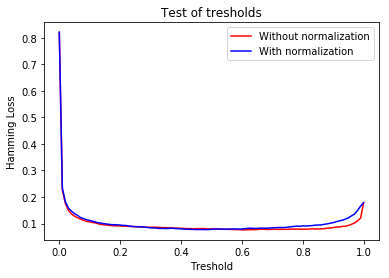

In [13]:
plt.figure()
plt.plot(tresholds, losses_4, 'r-', label="Without normalization")
plt.plot(tresholds, losses_4_norm, 'b-', label="With normalization")
plt.xlabel('Treshold')
plt.ylabel("Hamming Loss")
plt.legend()
plt.title("Test of tresholds")
plt.show()

# Execution time

In [18]:
t0 = time()
Y_pred = h.predict(X_test)
t1 = time() - t0
loss = np.mean(Y_pred != Y_test)
print(t1)

0.028985023498535156


# --------------OTHER----------------

In [9]:
for i in nb_layers:
    epoch, loss = run_network(nb_layers=i)
    epoc_layers.append(epoch)
    loss_layers.append(loss)



########## Training NN with nb_layers=2, learning_rate=0.005 ##########
Epoch: 0010 cost=0.918037775 time=1.1043
Epoch: 0020 cost=0.459171785 time=1.8754
Epoch: 0030 cost=0.369346945 time=2.4708
Epoch: 0040 cost=0.276843056 time=2.8816
Epoch: 0050 cost=0.234859235 time=3.6275
Epoch: 0060 cost=0.213204223 time=4.4014
Epoch: 0070 cost=0.238543787 time=4.9224
Epoch: 0080 cost=0.234764900 time=5.5643
Epoch: 0090 cost=0.202780784 time=5.9769
Epoch: 0100 cost=0.166624355 time=6.3943
Epoch: 0110 cost=0.155759962 time=6.8054
Epoch: 0120 cost=0.150211074 time=7.2070
Epoch: 0130 cost=0.163862272 time=7.6111
Epoch: 0140 cost=0.171362211 time=8.0141
Epoch: 0150 cost=0.187248999 time=8.5656
Epoch: 0160 cost=0.140899043 time=8.9680
Epoch: 0170 cost=0.134098827 time=9.4150
Epoch: 0180 cost=0.132008977 time=9.9729
Epoch: 0190 cost=0.173718531 time=10.5471
Epoch: 0200 cost=0.159065766 time=11.4183
Epoch: 0210 cost=0.158318786 time=12.4244
Epoch: 0220 cost=0.144294464 time=13.2049
Epoch: 0230 cost=0.1

In [10]:
for j in learning_rates:
    epoch, loss = run_network(learning_rate=j)
    epoc_learning.append(epoch)
    loss_learning.append(loss)



########## Training NN with nb_layers=2, learning_rate=0.0001 ##########
Epoch: 0010 cost=16.681147337 time=3.3853
Epoch: 0020 cost=15.675795627 time=4.6885
Epoch: 0030 cost=14.772673774 time=5.6451
Epoch: 0040 cost=13.934498835 time=6.4440
Epoch: 0050 cost=13.147479916 time=7.2466
Epoch: 0060 cost=12.404965854 time=8.0341
Epoch: 0070 cost=11.702362847 time=8.9570
Epoch: 0080 cost=11.036790395 time=10.0835
Epoch: 0090 cost=10.405831766 time=10.8905
Epoch: 0100 cost=9.807422280 time=11.6845
Epoch: 0110 cost=9.239753699 time=12.5431
Epoch: 0120 cost=8.701314592 time=13.3501
Epoch: 0130 cost=8.190835500 time=14.1580
Epoch: 0140 cost=7.707165074 time=14.9682
Epoch: 0150 cost=7.249249732 time=15.7796
Epoch: 0160 cost=6.816090405 time=16.5736
Epoch: 0170 cost=6.406672382 time=17.3632
Trained 170 epochs in 15 seconds.


########## Training NN with nb_layers=2, learning_rate=0.001 ##########
Epoch: 0010 cost=11.404170537 time=4.1519
Epoch: 0020 cost=6.612439275 time=5.0302
Epoch: 0030 cost=3

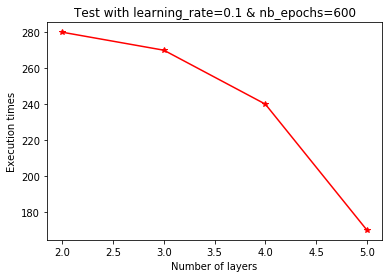

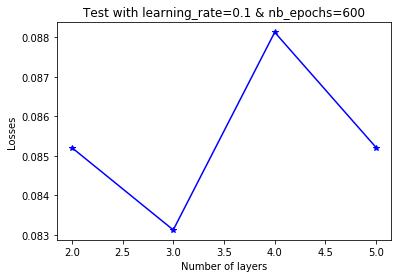

In [12]:
plt.figure()
plt.plot(nb_layers, epoc_layers, 'r*-')
plt.xlabel('Number of layers')
plt.ylabel("Number of epochs")
plt.title("Test with learning_rate=0.005")
plt.show()

plt.figure()
plt.plot(nb_layers, loss_layers, 'b*-')
plt.xlabel('Number of layers')
plt.ylabel("Hamming loss")
plt.title("Test with learning_rate=0.005")
plt.show()

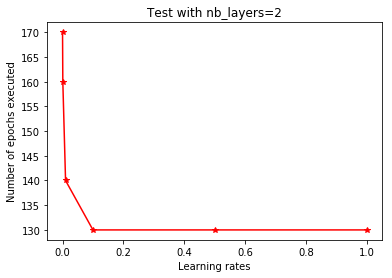

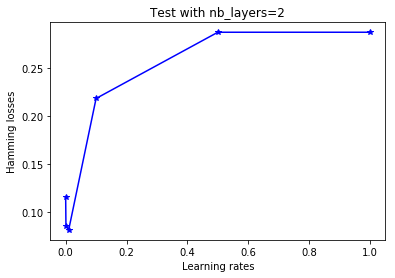

In [16]:
plt.figure()
plt.plot(learning_rates, epoc_learning, 'r*-')
plt.xlabel('Learning rates')
plt.ylabel("Number of epochs executed")
plt.title("Test with nb_layers=2")
plt.show()

plt.figure()
plt.plot(learning_rates, loss_learning, 'b*-')
plt.xlabel('Learning rates')
plt.ylabel("Hamming losses")
plt.title("Test with nb_layers=2")
plt.show()

## For nb_epochs

In [ ]:
h = Network(learning_rate=0.5, nb_layers=4)
exec_time = 0

def run_network_for_epochs(nb_epochs):
    global exec_time

    t0 = clock()
    h.fit(X_train,Y_train,n_epochs=nb_epochs)
    exec_time += int(clock() - t0)

    Y_pred = h.predict(X_test)
    loss = np.mean(Y_pred != Y_test)

    return exec_time, loss

In [ ]:
nb_epochs       = [100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100]
nb_epochs_total = np.cumsum(nb_epochs)
time_epoch      = []
loss_epoch      = []

In [ ]:
for k in nb_epochs:
    exec_time, loss = run_network_for_epochs(nb_epochs=k)
    time_epoch.append(exec_time)
    loss_epoch.append(loss)

In [ ]:
plt.figure()
plt.plot(nb_epochs_total, time_epoch, 'r*-')
plt.xlabel('Number of epochs')
plt.ylabel("Execution times")
plt.title("Test with nb_layers=4 & learning_rate=0.1")
plt.show()

plt.figure()
plt.plot(nb_epochs_total, loss_epoch, 'b*-')
plt.xlabel('Number of epochs')
plt.ylabel("Losses")
plt.title("Test with nb_layers=4 & learning_rate=0.1")
plt.show()

# Second test

In [ ]:
def run_network_bis(nb_layers=4, learning_rate=0.3, nb_epochs=750):
    
    print("\n\n########## Training NN with nb_layers={}, learning_rate={}, nb_epoch={} ##########".format(nb_layers,learning_rate,nb_epochs))

    t0 = clock()
    h = Network(learning_rate=learning_rate, nb_layers=nb_layers)

    h.fit(X_train,Y_train,n_epochs=nb_epochs, warm_start=False)

    exec_time = int(clock() - t0)

    Y_pred = h.predict(X_test)
    loss = np.mean(Y_pred != Y_test)

    return exec_time, loss

In [ ]:
learning_rates = [0.01, 0.1, 0.3, 0.5, 0.7, 1]
time_learning  = []
loss_learning  = []

In [ ]:
for j in learning_rates:
    exec_time, loss = run_network_bis(learning_rate=j)
    time_learning.append(exec_time)
    loss_learning.append(loss)

In [ ]:
plt.figure()
plt.figure()
plt.plot(learning_rates, loss_learning, 'b*-')
plt.xlabel('Learning rates')
plt.ylabel("Losses")
plt.title("Test with nb_layers=4 & nb_epochs=750")
plt.show()

In [ ]:
h = Network(learning_rate=0.5, nb_layers=4)
exec_time = 0

def run_network_for_epochs_bis(nb_epochs):
    t0 = clock()
    global exec_time

    h.fit(X_train,Y_train,n_epochs=nb_epochs)
    exec_time += int(clock() - t0)

    Y_pred = h.predict(X_test)
    loss = np.mean(Y_pred != Y_test)

    return exec_time, loss

In [ ]:
nb_epochs       = [200,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50]
nb_epochs_total = np.cumsum(nb_epochs)
time_epoch      = []
loss_epoch      = []

In [ ]:
for k in nb_epochs:
    exec_time, loss = run_network_for_epochs_bis(nb_epochs=k)
    time_epoch.append(exec_time)
    loss_epoch.append(loss)

In [ ]:
plt.figure()
plt.figure()
plt.plot(nb_epochs_total, loss_epoch, 'b*-')
plt.xlabel('Number of epochs')
plt.ylabel("Losses")
plt.title("Test with nb_layers=4 & learning_rate=0.5")
plt.show()

# Other tests